# Optimization of a circulator layout

Author: Alexis Morvan
Date: 2021-06-02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.check_solution import *
from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# import pandas as pd

## Definition of the layout
We are defining a circular layout of N-transmons. Here we consider a simple circular layout where the edge goes likes:

0 --> 1 --> 2 --> ... --> N//2 <-- ... <-- N-1 <-- N <-- 0

### Ring parameters

In [2]:
N = 6  # number of transmons
edges = [(0, 1), (1, 2), (2, 3), (4, 3), (5, 4), (0, 5)]  # edges
architecture = "CZ"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

### Constructing a FrequencyGraph object

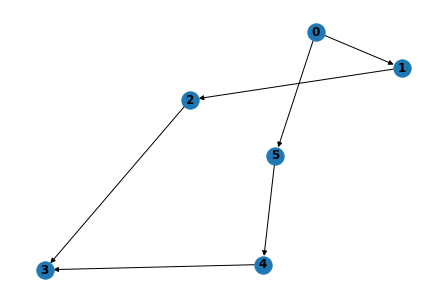

In [3]:
G = FrequencyGraph(edges=edges, cz=cz)
G.plot()

In [4]:
G.cz

True

## Optimization of the frequency

### optimization parameters

In [5]:
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             qutrit=qutrit,
                             all_differents=all_differents)

### Optimization

In [6]:
# perform the optimization
optimizer.declare_solver()
optimizer.first_pass()
optimizer.second_pass()
result = optimizer.third_pass()

### Adding the results to the frequencyGraph

In [7]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)

[]

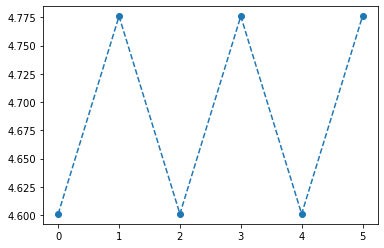

In [8]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')
ax.plot()

## Yield of the design

In [51]:
#thresholds
# d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
# cstr_key = cr_keys

# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

# free of drive
keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
d_dict = { k: dd for (k, dd) in zip(keys, d)}
cstr_key = keys

True
Qubit collisions:
yield   = 0.8575033333333333
average = 0.16717333333333334


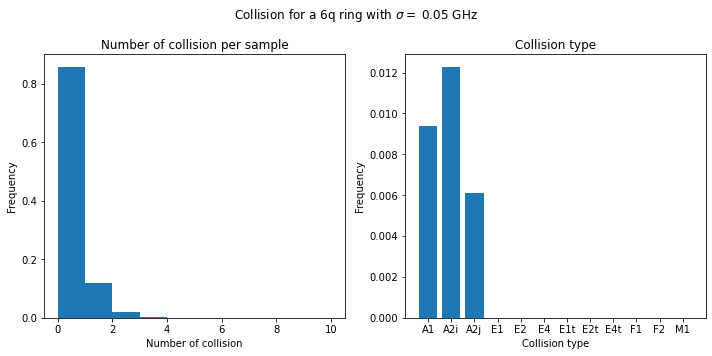

In [52]:
# parametrization
Nsamples = 300000
sigma = 0.05

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot of the yield
ax = axs[0]
print(G.cz)
collisions, c, idx_list, constraints = G.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 


ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)
# ax.hist(collisions, density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")

# histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')

ax.set_title("Collision type")

fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

### Collision type distribution

### Collision spatial distribution

In [53]:
x = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
xm = [(x[i] + x[i+1])/2 for i in range(len(x)-1)]

Text(0.5, 0, 'Collision type')

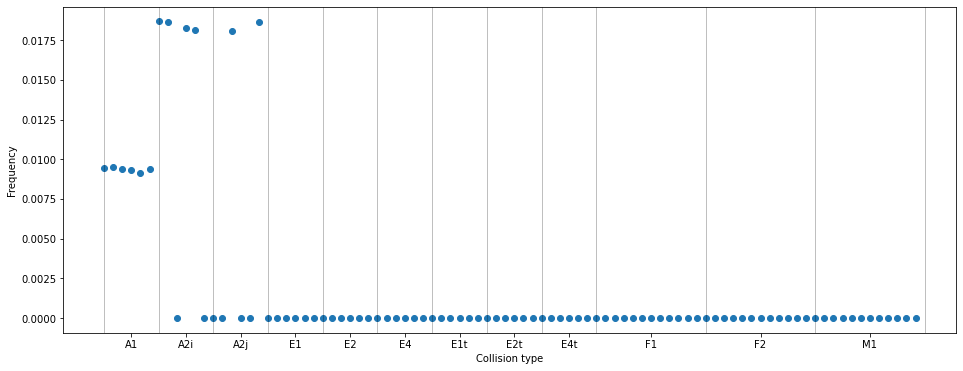

In [54]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.sum(~np.array(c), axis=1)/Nsamples, 'o')
for xx in x:
    ax.axvline(xx, color='k', linewidth=0.5, alpha = 0.5)
ax.set_xticks(xm);
ax.set_xticklabels(constraints)

ax.set_ylabel('Frequency')
ax.set_xlabel("Collision type")

### Collision vs std of the frequencies

(0.0, 100.0)

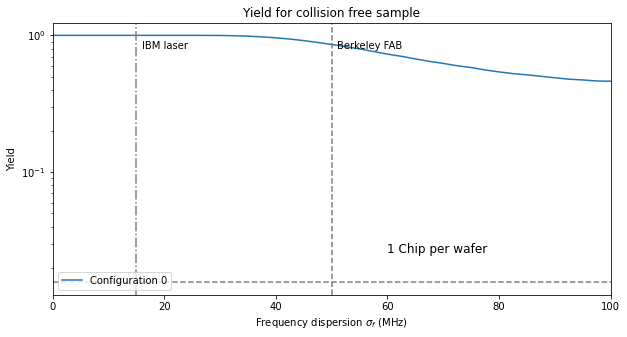

In [55]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples=100000

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.1, 41)

# saving the results
collisions = np.array([G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')

# 1/64 limit
ax.axhline(1/64, ls='--', color='Gray')
ax.text(60, 1/64+0.01, '1 Chip per wafer', fontsize=12)

ax.axvline(15, ls='-.', color='Gray')
ax.text(16, 0.8, 'IBM laser')
ax.axvline(50, ls='--', color='Gray')
ax.text(51, 0.8, 'Berkeley FAB')
# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=3)

ax.set_xlim(0, 100)

In [40]:
collisions_CR = collisions

In [13]:
collisions_CZ = collisions

(0.0, 100.0)

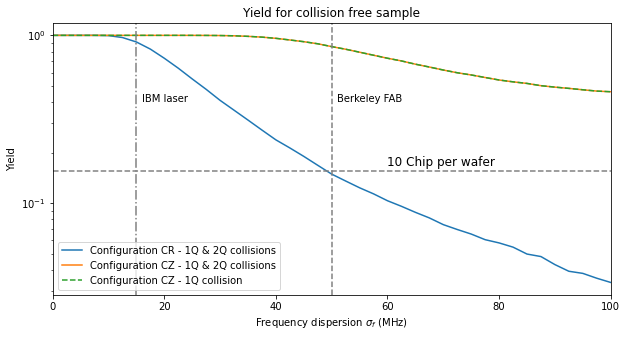

In [66]:
fig, ax = plt.subplots( figsize=(10, 5))
n_collisions = [0]
y_cr = [(Nsamples-np.count_nonzero(collisions_CR-n, axis=1))/Nsamples for n in n_collisions]
y_cz = [(Nsamples-np.count_nonzero(collisions_CZ-n, axis=1))/Nsamples for n in n_collisions]

y_sq = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y_cr[0], label=f'Configuration CR - 1Q & 2Q collisions')
ax.plot(s_vec*1e3, y_cz[0], label=f'Configuration CZ - 1Q & 2Q collisions')
ax.plot(s_vec*1e3, y_cz[0], label=f'Configuration CZ - 1Q collision', ls='--')

# 1/64 limit
ax.axhline(10/64, ls='--', color='Gray')
ax.text(60, 10/64+0.01, '10 Chip per wafer', fontsize=12)

ax.axvline(15, ls='-.', color='Gray')
ax.text(16, 0.4, 'IBM laser')
ax.axvline(50, ls='--', color='Gray')
ax.text(51, 0.4, 'Berkeley FAB')
# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=3)

ax.set_xlim(0, 100)